<a href="https://colab.research.google.com/github/fullstackDonya/recognition/blob/main/facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

modèle CNN pour la détection d’émotions avec le dataset FER2013, l'entraînement, la sauvegarde et la prédiction en temps réel via webcam

In [3]:
%pip install opencv-python
%pip install tensorflow
%pip install flask
%pip install kagglehub
%pip install flask-cors

In [5]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/fer2013


In [8]:
import os
import numpy as np
import cv2
import kagglehub
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# 1. Paramètres
image_size = (48, 48)
batch_size = 32
num_classes = 7
epochs = 15

# 2. Téléchargement du dataset FER2013 via KaggleHub
dataset_path = kagglehub.dataset_download("msambare/fer2013")

# 3. Préparation des données avec ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical"
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical"
)

# 4. Définition du modèle CNN
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# 5. Sauvegarde du meilleur modèle avec ModelCheckpoint
checkpoint_path = "emotion_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)

# 6. Entraînement du modèle
model.fit(train_generator, validation_data=test_generator, epochs=epochs, callbacks=[checkpoint])

# 7. Chargement du meilleur modèle
model = load_model(checkpoint_path)

# 8. Fonction de prédiction temps réel via webcam
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(model):
    cap = cv2.VideoCapture(0)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            roi = gray_frame[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, image_size)
            roi_normalized = roi_resized / 255.0
            roi_reshaped = np.reshape(roi_normalized, (1, 48, 48, 1))
            prediction = model.predict(roi_reshaped)
            label = emotion_labels[np.argmax(prediction)]

            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Emotion Detection", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

# 9. Lancer la prédiction temps réel
# Décommente la ligne ci-dessous pour activer la détection en temps réel :
# predict_emotion(model)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2811 - loss: 1.7626

898/898 ━━━━━━━━━━━━━━━━━━━━ 130s 142ms/step - accuracy: 0.2811 - loss: 1.7624 - val_accuracy: 0.4542 - val_loss: 1.4382
Epoch 2/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4426 - loss: 1.4445

898/898 ━━━━━━━━━━━━━━━━━━━━ 139s 139ms/step - accuracy: 0.4426 - loss: 1.4445 - val_accuracy: 0.5029 - val_loss: 1.2988
Epoch 3/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5026 - loss: 1.3067

898/898 ━━━━━━━━━━━━━━━━━━━━ 125s 139ms/step - accuracy: 0.5026 - loss: 1.3067 - val_accuracy: 0.5270 - val_loss: 1.2320
Epoch 4/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.5389 - loss: 1.2306 - val_accuracy: 0.5269 - val_loss: 1.2232
Epoch 5/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5693 - loss: 1.1478

898/898 ━━━━━━━━━━━━━━━━━━━━ 137s 153ms/step - accuracy: 0.5693 - loss: 1.1478 - val_accuracy: 0.5563 - val_loss: 1.1733
Epoch 6/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5809 - loss: 1.0942

898/898 ━━━━━━━━━━━━━━━━━━━━ 124s 138ms/step - accuracy: 0.5809 - loss: 1.0942 - val_accuracy: 0.5676 - val_loss: 1.1560
Epoch 7/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6073 - loss: 1.0483

898/898 ━━━━━━━━━━━━━━━━━━━━ 125s 139ms/step - accuracy: 0.6073 - loss: 1.0483 - val_accuracy: 0.5678 - val_loss: 1.1583
Epoch 8/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6256 - loss: 0.9950

898/898 ━━━━━━━━━━━━━━━━━━━━ 127s 142ms/step - accuracy: 0.6256 - loss: 0.9950 - val_accuracy: 0.5691 - val_loss: 1.1565
Epoch 9/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6426 - loss: 0.9495

898/898 ━━━━━━━━━━━━━━━━━━━━ 124s 138ms/step - accuracy: 0.6426 - loss: 0.9495 - val_accuracy: 0.5756 - val_loss: 1.1393
Epoch 10/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 126s 141ms/step - accuracy: 0.6583 - loss: 0.8871 - val_accuracy: 0.5752 - val_loss: 1.1671
Epoch 11/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6808 - loss: 0.8453

898/898 ━━━━━━━━━━━━━━━━━━━━ 126s 141ms/step - accuracy: 0.6808 - loss: 0.8453 - val_accuracy: 0.5791 - val_loss: 1.1846
Epoch 12/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 143s 142ms/step - accuracy: 0.7003 - loss: 0.8016 - val_accuracy: 0.5756 - val_loss: 1.2154
Epoch 13/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 138s 138ms/step - accuracy: 0.7115 - loss: 0.7609 - val_accuracy: 0.5745 - val_loss: 1.2488
Epoch 14/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 144s 141ms/step - accuracy: 0.7326 - loss: 0.7043 - val_accuracy: 0.5692 - val_loss: 1.2951
Epoch 15/15
898/898 ━━━━━━━━━━━━━━━━━━━━ 127s 141ms/step - accuracy: 0.7405 - loss: 0.6844 - val_accuracy: 0.5745 - val_loss: 1.3140


In [9]:
# Sauvegarder le modèle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Sauvegarde du modèle entraîné
model.save("/content/drive/MyDrive/Colab Notebooks/SY/emotion_model.h5")
model.save("/content/drive/MyDrive/Colab Notebooks/SY/emotion_model.keras")

In [11]:
# 9. Lancer la prédiction temps réel
# activer la détection en temps réel :
predict_emotion(model)

In [19]:
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.2f}, Loss: {loss:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5848 - loss: 1.1853
Test accuracy: 0.58, Loss: 1.1846


225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step
              precision    recall  f1-score   support

       Angry       0.13      0.16      0.14       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.14      0.09      0.11      1024
       Happy       0.24      0.26      0.25      1774
         Sad       0.17      0.15      0.16      1233
    Surprise       0.18      0.22      0.20      1247
     Neutral       0.12      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



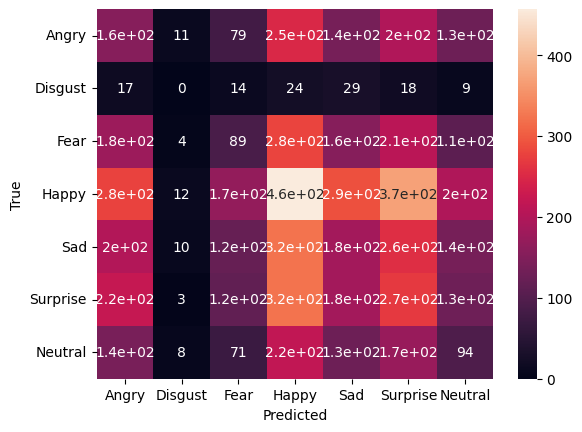

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prédictions sur le test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Rapport et matrice de confusion
print(classification_report(y_true, y_pred, target_names=emotion_labels))
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
